In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
import sys, os, pathlib
os.environ['PKG_CONFIG_PATH'] = '/ocean/projects/asc170022p/mtragoza/mambaforge/envs/lung-project/lib/pkgconfig'

import numpy as np
import pandas as pd
import nibabel as nib

import pygalmesh
import meshio
import fenics as fe
from mpi4py import MPI

sys.path.append('../..')
import project

In [3]:
%autoreload
data_root = pathlib.Path('/ocean/projects/asc170022p/mtragoza/lung-project/data/COPDGene')
data_file = data_root / 'sample1000_2025-07-22.csv'

# load sampled data file
df_sampled = pd.read_csv(data_file, sep='\t', low_memory=False)
df_sampled

,sid,ccenter,kernel,Emphysema,pctEmph,pctEmph_Slicer,FEV1pp_utah,FVCpp_utah,FEV1_FVC_utah,finalGold,catEmph
0,16514P,TEM,STD,0,0.3373,0.3147,77.6,88.9,0.71,-1.0,normal
1,20748Q,UAB,STD,0,3.6045,3.4085,73.2,75.8,0.75,-1.0,normal
2,11007Z,USD,STD,0,0.3126,0.2867,66.7,108.0,0.47,2.0,normal
3,14771Z,HPR,STD,0,0.3160,0.2948,94.1,97.0,0.73,0.0,normal
4,13651K,UIA,STD,0,2.0807,1.9551,85.1,88.0,0.75,0.0,normal
...,...,...,...,...,...,...,...,...,...,...,...
995,20519B,DUK,STD,1,30.1942,29.6440,19.9,69.2,0.22,4.0,severe
996,12294H,UAB,STD,1,40.3908,39.5845,43.3,86.0,0.37,3.0,severe
997,23123R,TEM,STD,0,23.6838,22.7617,42.8,72.7,0.45,3.0,severe
998,16546C,UIA,STD,1,42.6116,41.8307,58.6,99.6,0.43,2.0,severe


In [4]:
dataset = project.copdgene.COPDGeneDataset(df_sampled, data_root)
dataset

In [5]:
row, visit = dataset[0]
row

sid               16514P
ccenter              TEM
kernel               STD
Emphysema              0
pctEmph           0.3373
pctEmph_Slicer    0.3147
FEV1pp_utah         77.6
FVCpp_utah          88.9
FEV1_FVC_utah       0.71
finalGold           -1.0
catEmph           normal
Name: 0, dtype: object

In [6]:
variant = 'RAW'
image_name = visit.build_image_name(state='EXP', recon='STD')
mask_name = 'lung_regions'

In [7]:
mask_path = visit.mask_file(variant, image_name, mask_name)
mask_nifti = nib.load(mask_path)
mask_array = mask_nifti.get_fdata()
resolution = mask_nifti.header.get_zooms()
print(mask_array.shape, resolution)

(512, 512, 537) (0.71875, 0.71875, 0.5)


In [10]:
mesh_raw = pygalmesh.generate_from_array(
    mask_array.astype(np.uint16),
    voxel_size=resolution,
    max_cell_circumradius=min(resolution)*20,
    max_facet_distance=min(resolution)*2,
    verbose=True
)
mesh_raw

<meshio mesh object>
  Number of points: 13752
  Number of cells:
    triangle: 46994
    tetra: 68447
  Point data: medit:ref
  Cell data: medit:ref

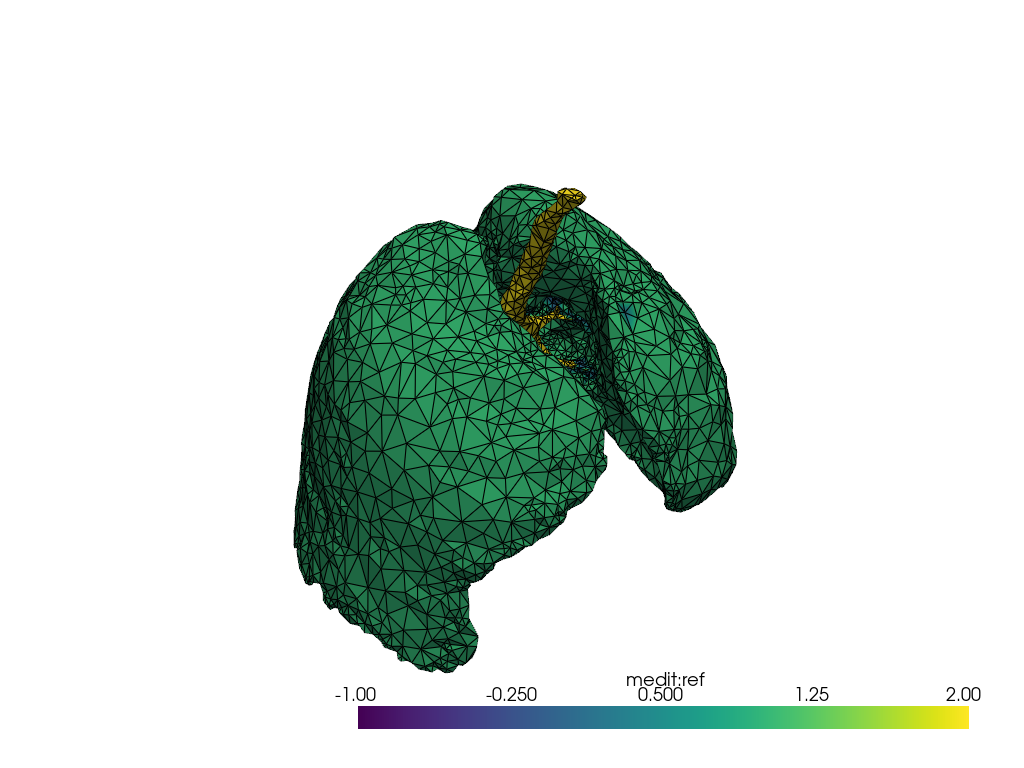

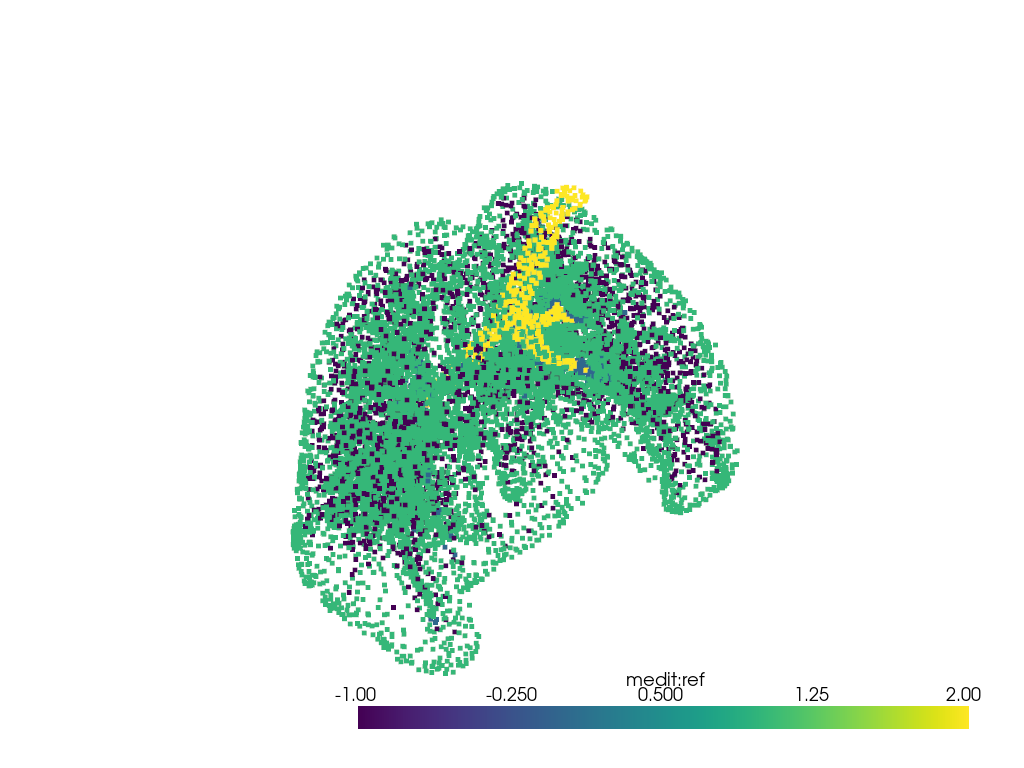

<meshio mesh object>
  Number of points: 13752
  Number of cells:
    triangle: 46994
    tetra: 68447
  Point data: medit:ref
  Cell data: medit:ref

In [11]:
import pyvista as pv
pv.start_xvfb()
from IPython.display import Image, display

def plot_mesh(mesh, **kwargs):
    m = pv.from_meshio(mesh)

    p = pv.Plotter()
    p.add_mesh(m, **kwargs)
    p.view_isometric()

    p.screenshot('temp.png')
    display(Image(filename='temp.png'))

def plot_points(mesh, **kwargs):
    m = pv.PolyData(mesh.points)
    for k, v in mesh.point_data.items():
        m.point_data[k] = v

    p = pv.Plotter()
    p.add_mesh(m, **kwargs)

    p.screenshot('temp.png')
    display(Image(filename='temp.png'))

plot_mesh(mesh_raw, show_edges=True)
plot_points(mesh_raw)
mesh_raw

In [15]:
%autoreload
project.meshing.construct_label_map(mesh_raw, mask_array, resolution)

array([-1,  1,  6,  7])

In [16]:
%autoreload
project.meshing.count_connected_components(mesh_raw, cell_type='tetra')

1

In [17]:
mesh_labeled = project.meshing.assign_cell_labels(mesh_raw, mask_array, resolution)
mesh_labeled

<meshio mesh object>
  Number of points: 13752
  Number of cells:
    triangle: 46994
    tetra: 68447
  Cell data: label

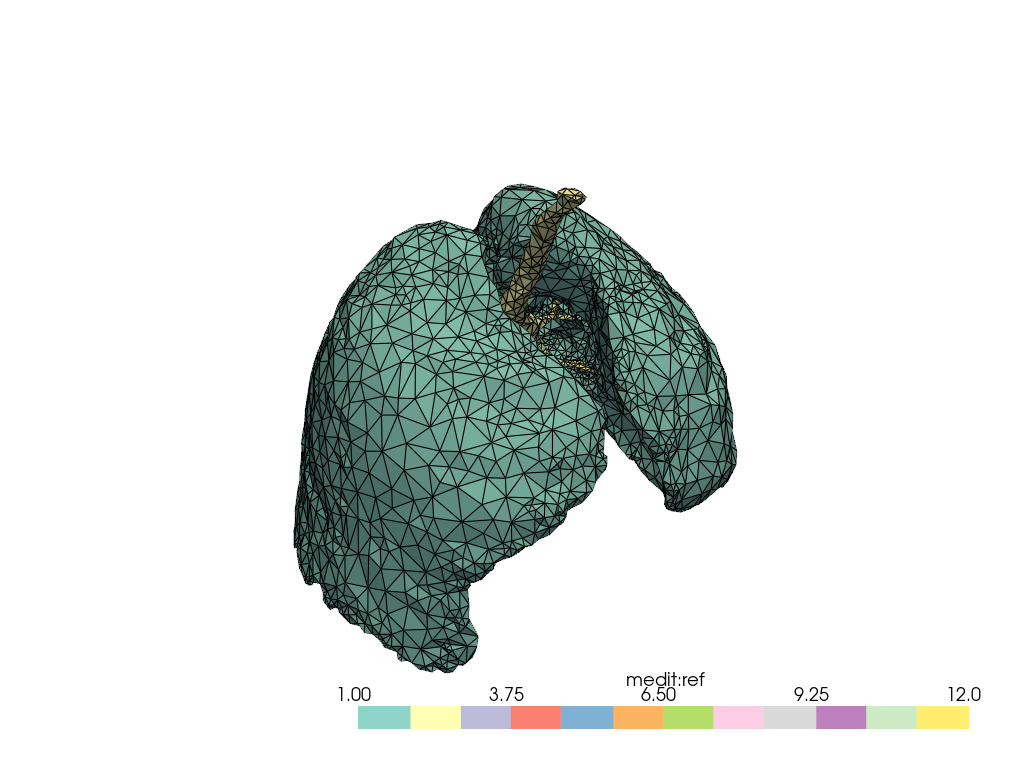

<meshio mesh object>
  Number of points: 13752
  Number of cells:
    triangle: 46994
    tetra: 68447
  Cell data: medit:ref

In [18]:
mesh_cleaned = project.meshing.remove_unused_points(mesh_raw)

plot_mesh(mesh_cleaned, show_edges=True, cmap='Set3', clim=(1, 12))
mesh_cleaned

In [19]:
project.meshing.count_connected_components(mesh_cleaned, 'tetra')

1

In [23]:
%autoreload
project.meshing.generate_mesh_from_mask(mask_array, resolution)

{'triangle': <meshio mesh object>
   Number of points: 13752
   Number of cells:
     triangle: 46994
   Cell data: label,
 'tetra': <meshio mesh object>
   Number of points: 13752
   Number of cells:
     tetra: 68457
   Cell data: label}

In [24]:
%autoreload
mesh, labels = project.meshing.generate_anatomical_mesh(visit, variant, image_name)

Loading /ocean/projects/asc170022p/mtragoza/lung-project/data/COPDGene/Images/16514P/Phase-1/RAW/TotalSegmentator/16514P_EXP_STD_TEM_COPD/lung_regions.nii.gz
Generating mesh from mask
Saving /ocean/projects/asc170022p/mtragoza/lung-project/data/COPDGene/Images/16514P/Phase-1/RAW/pygalmesh/16514P_EXP_STD_TEM_COPD/lung_regions_volume.xdmf
Saving /ocean/projects/asc170022p/mtragoza/lung-project/data/COPDGene/Images/16514P/Phase-1/RAW/pygalmesh/16514P_EXP_STD_TEM_COPD/lung_regions_surface.xdmf


In [25]:
mesh